# Deep Cross-Entropy Method, 8 pts + bonuses

In this section we'll extend your CEM implementation with neural networks. You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from another notebook.__


In [1]:
# Install necessary libraries. If you encounter difficulties in local installation, use google colab.

!pip install swig
!pip install gymnasium[toy_text,classic_control,box2d]

Here we start with [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment. As usual, first of all read the description of the environment: what are the goals of the game, what are observations and actions, how reward is calculated, etc.

state vector dim = 4
n_actions = 2


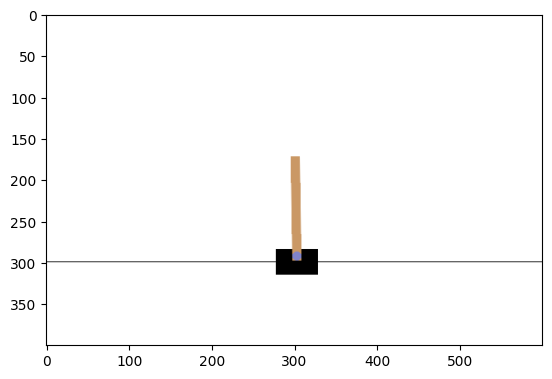

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v1", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

Let's play with the environment with random strategy and generate a video with results

In [3]:
from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:

    s, info = env_monitor.reset()
    for t in range(100):
        a = env_monitor.action_space.sample()
        s, r, terminated, truncated, info = env_monitor.step(a)
        if terminated or truncated:
            break

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [4]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[0]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [5]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [6]:
def generate_session(env, agent, t_max=1000, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, info = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        if test:
            # on the test use the best (the most likely) actions at test
            # experiment, will it work on the train and vice versa?
            a = np.argmax(probs)
            # ^-- hint: try np.argmax
        else:
            # sample proportionally to the probabilities,
            # don't just take the most likely action at train
            a = np.random.choice(np.arange(len(probs)), p=probs)
            # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward


In [7]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[-0.02757067  0.00211508  0.03896257  0.0100388 ]
 [-0.02752837  0.19665721  0.03916334 -0.27010086]
 [-0.02359523  0.39119905  0.03376133 -0.55017877]
 [-0.01577125  0.5858309   0.02275775 -0.83203626]
 [-0.00405463  0.39040548  0.00611703 -0.5322838 ]]
actions: [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
reward: 5.0


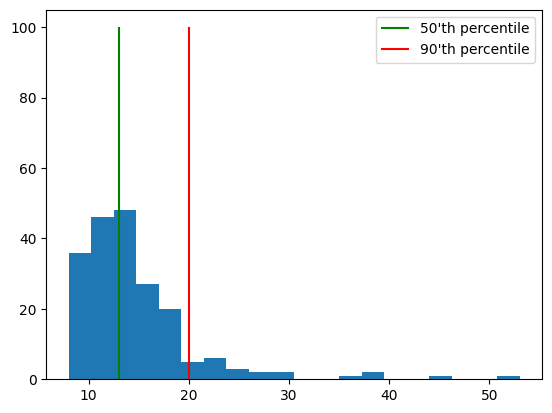

In [8]:
# let's see the initial reward distribution
sample_rewards = [generate_session(env, agent, t_max=1000, test=False)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

In [9]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    # <YOUR CODE>
    reward_threshold = np.percentile(rewards_batch, percentile)

    if np.all(rewards_batch <= reward_threshold):
        top_n = max(1, len(rewards_batch) // 10)
        elite_indices = np.argsort(rewards_batch)[-top_n:]
    else:
        elite_indices = [i for i, r in enumerate(rewards_batch) if r > reward_threshold]

    elite_states = []
    elite_actions = []
    for idx in elite_indices:
        elite_states.extend(states_batch[idx])
        elite_actions.extend(actions_batch[idx])

    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those. Here we don't need to solve the environment with the best possible quality. Just reaching a mean reward 190 is enough.

In [10]:
n_sessions = 100
percentile = 50
log = []

for i in range(n_sessions):
    # generate new sessions
    sessions = [ generate_session(env, agent) for _ in range(n_sessions) ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # < estimate mean reward and print >

    mean_reward = np.mean(rewards_batch)
    print(f"Iteration {i + 1}: Mean reward = {mean_reward}")
    log.append(mean_reward)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    # <partial_fit agent to predict elite_actions (y) from elite_states (X)>
    agent.partial_fit(elite_states, elite_actions)

    if mean_reward > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

Iteration 1: Mean reward = 14.18
Iteration 2: Mean reward = 14.4
Iteration 3: Mean reward = 16.02
Iteration 4: Mean reward = 14.74
Iteration 5: Mean reward = 15.86
Iteration 6: Mean reward = 19.1
Iteration 7: Mean reward = 19.44
Iteration 8: Mean reward = 20.52
Iteration 9: Mean reward = 19.1
Iteration 10: Mean reward = 23.72
Iteration 11: Mean reward = 26.42
Iteration 12: Mean reward = 22.96
Iteration 13: Mean reward = 25.1
Iteration 14: Mean reward = 26.96
Iteration 15: Mean reward = 30.06
Iteration 16: Mean reward = 32.24
Iteration 17: Mean reward = 33.16
Iteration 18: Mean reward = 32.48
Iteration 19: Mean reward = 34.7
Iteration 20: Mean reward = 33.56
Iteration 21: Mean reward = 34.84
Iteration 22: Mean reward = 34.52
Iteration 23: Mean reward = 35.86
Iteration 24: Mean reward = 36.08
Iteration 25: Mean reward = 38.32
Iteration 26: Mean reward = 39.34
Iteration 27: Mean reward = 37.28
Iteration 28: Mean reward = 40.36
Iteration 29: Mean reward = 47.62
Iteration 30: Mean reward = 

# Results

Let's generate a video for our trained policy

In [11]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(5)]


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [12]:
# Show video

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[0]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# The Assignment

### Deep Cross-Entropy Method

By this moment, you should have got enough score on CartPole-v1 to consider it solved. It's time to try something harder.

### Tasks

* __2.1__ (**3pts**) Pick one of environments: [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/) or [LunarLander-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result.
  
  
* __2.2__ Devise a way to speed up training against the default version
  * (**2pts**) Try re-using samples from 3-5 last iterations when computing threshold and training.
  * (**3pts**) Obtain **-100** at MountainCar-v0 or **+200** at LunarLander-v2.Feel free to experiment with hyperparameters, architectures, schedules etc.
    
  
### Tips
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue.
* 20-neuron network is probably not enough, feel free to experiment.


### Bonus tasks (Up to 6 points)

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
  * Slightly less points for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.
  

state vector dim = 2
n_actions = 3


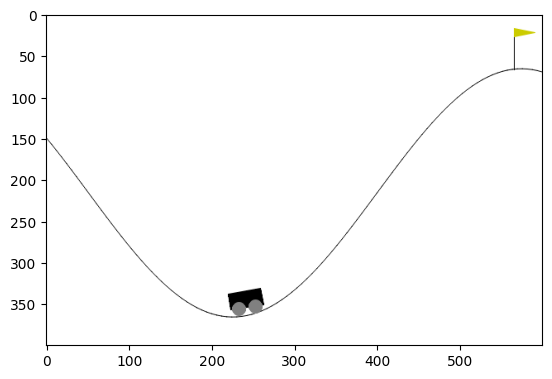

In [13]:
env_mc0 = gym.make("MountainCar-v0", render_mode='rgb_array').env

np.random.seed(2000)

env_mc0.reset()
n_actions_mc0 = env_mc0.action_space.n
state_dim_mc0 = env_mc0.observation_space.shape[0]

plt.imshow(env_mc0.render())
print("state vector dim =", state_dim_mc0)
print("n_actions =", n_actions_mc0)

In [14]:
from sklearn.neural_network import MLPClassifier
agent_mc0 = MLPClassifier(hidden_layer_sizes=(100, 100),
                          activation='tanh',
                          warm_start=True,
                          max_iter=1)

agent_mc0.partial_fit([env_mc0.reset()[0]] * n_actions_mc0, range(n_actions_mc0), range(n_actions_mc0))

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100), max_iter=1,
              warm_start=True)

In [20]:
def generate_session_mc0(env, agent, t_max=10000, final=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, info = env.reset()

    for t in range(t_max):
        probs = agent.predict_proba([s])
        probs = np.reshape(probs, (env.action_space.n,))

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector"

        a = np.random.choice(env.action_space.n, p=probs)

        new_s, r, terminated, truncated, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        if final:
            from IPython.display import clear_output
            import matplotlib.pyplot as plt
            clear_output(True)
            plt.imshow(env.render())
            plt.axis('off')
            plt.show()

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward

In [16]:
n_sessions = 150
percentile = 45
log = []

for i in range(n_sessions):
    # generate new sessions
    sessions = [ generate_session_mc0(env_mc0, agent_mc0) for _ in range(n_sessions) ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # < estimate mean reward and print >

    mean_reward = np.mean(rewards_batch)
    print(f"Iteration {i + 1}: Mean reward = {mean_reward}")
    log.append(mean_reward)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    # <partial_fit agent to predict elite_actions (y) from elite_states (X)>
    if elite_states:
        agent_mc0.partial_fit(elite_states, elite_actions)
    else:
        print(f"Iteration {i + 1}: No elite sessions selected.")


    if mean_reward > -100:
        print("You Win! You may stop training now via KeyboardInterrupt.")

Iteration 1: Mean reward = -8330.89
Iteration 2: Mean reward = -7299.29
Iteration 3: Mean reward = -7040.66
Iteration 4: Mean reward = -5777.7
Iteration 5: Mean reward = -5325.54
Iteration 6: Mean reward = -5088.28
Iteration 7: Mean reward = -3794.66
Iteration 8: Mean reward = -3842.14
Iteration 9: Mean reward = -4208.38
Iteration 10: Mean reward = -4073.23
Iteration 11: Mean reward = -3258.82
Iteration 12: Mean reward = -2261.84
Iteration 13: Mean reward = -1697.76
Iteration 14: Mean reward = -1522.01
Iteration 15: Mean reward = -1365.15
Iteration 16: Mean reward = -1006.26
Iteration 17: Mean reward = -839.49
Iteration 18: Mean reward = -833.93
Iteration 19: Mean reward = -969.8
Iteration 20: Mean reward = -842.18
Iteration 21: Mean reward = -765.37
Iteration 22: Mean reward = -763.54
Iteration 23: Mean reward = -579.14
Iteration 24: Mean reward = -599.38
Iteration 25: Mean reward = -580.72
Iteration 26: Mean reward = -597.33
Iteration 27: Mean reward = -535.34
Iteration 28: Mean rewa

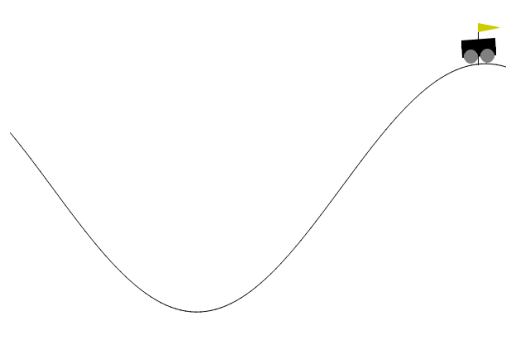

-143.0

In [23]:
from IPython.display import clear_output

[_,_,reward] = generate_session_mc0(env_mc0, agent_mc0, final=True)

reward